In [284]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import scipy.stats as ss
from functools import partial
from pandas import Series, DataFrame, Panel
%matplotlib inline
%precision 4

u'%.4f'

In [285]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
p1=importr('leaps')
p2=importr('stats')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# FSR Function Code

In [286]:

def fsr_fast(x,y,gam0,digits,pl):
    m = x.shape[1]
    n = x.shape[0]
    if(m >= n): 
        m1=n-5  
    else: 
        m1=m 
    vm = range(m1)
  # if only partially named columns corrects for no colnames
    pvm = [0] * m1
    out_x = p1.regsubsets(x,y,method="forward")  
    rss = out_x[9]
    nn = out_x[26][0]
    q = [(rss[i]-rss[i+1])*(nn-i-2)/rss[i+1] for i in range(len(rss)-1)]
    rvf = [ ss.f(1,nn-i-2)  for i in range(len(rss)-1)]
    orig =  [1-rvf[i].cdf(q[i]) for i in range(len(rss)-1)]

 # sequential max of pvalues
    for i in range(m1):
        pvm[i] = max(orig[0:i+1])
    alpha = [0]+pvm
    ng = len(alpha)
 # will contain num. of true entering in orig
    S = [0] * ng
 # loop through alpha values for S=size                        
    for ia in range(1,ng):                   
        S[ia] = sum([pvm[i] <= alpha[ia] for i in range(len(pvm))])        # size of models at alpha[ia], S[1]=0
    ghat = [(m-S[i])*alpha[i]/(1+S[i]) for i in range(len(alpha))]              # gammahat_ER 
 # add additional points to make jumps
    alpha2 = np.array(alpha[1:ng])-.0000001
    ghat2 = ((m-np.array(S[0:(ng-1)]))*alpha2)/(1+np.array(S[0:(ng-1)]))
    a= alpha+list(alpha2)
    g=ghat + list(ghat2)
    zp = {'a' : a,
     'g' : g}
    zp = pd.DataFrame(zp)  
    zp=np.array(zp)[np.argsort(zp.a)]
    index_max= np.argmax(zp[:,1])
    alphamax=zp[:,0][index_max]
    ind = [0]*len(ghat)
    ind = [ 1 if ghat[i]<gam0 and alpha[i]<=alphamax else 0 for i in range(len(ghat))]
    Sind = S[np.max(np.where(np.array(ind)>0))]
    alphahat_fast = (1+Sind)*gam0/(m-Sind)
    size1=np.sum(np.array(pvm)<=alphahat_fast)+1
    x=x[list(x.columns.values[list((np.array(out_x[7])-2)[1:size1])])]
    x=sm.add_constant(x)
    if(size1>1): 
        x_ind=(np.array(out_x[7])-1)[1:size1]
    else:
        x_ind=0
    if (size1==1):
        mod = np.mean(y)
    else:
        mod = sm.OLS(y, x).fit()
    ghat4=(m-size1+1)*np.array(alpha)/(1+np.array(range(m+1)))
 #plt.axis([0,alphamax,0,1.4]) 
    if pl == 1:
        plt.plot(zp[:,0],zp[:,1],'bo',color='red')
        plt.plot([alphahat_fast], [gam0], 'g.', markersize=20.0)
        plt.xlabel('Alpha')
        plt.ylabel('Estimated Gamma')
        plt.axvspan(xmin=-0.1, xmax=alphahat_fast, ymin=0, ymax=0.18)
    return mod,size1-1,x_ind,alphahat_fast

# Bagging FSR

In [287]:
def bag_fsr(x,y,B,gam0,fsr_fast,digits):
    m = x.shape[1]
    n = x.shape[0]
    hold = np.zeros((B,m+1))      # holds coefficients
    hold = pd.DataFrame(hold)
    alphahat = [0] * B                    # holds alphahats
    size = [0] * B
    for i in range(B):
        index = np.random.choice(n, n)
        out = fsr_fast(x.ix[index,:],y.ix[index],gam0,digits,0)
        if out[1]>0:
            hold.iloc[i,out[2]] = np.array(out[0].params)[1:(len(out[2])+1)]
        hold.iloc[i,0] = out[0].params[0]
        alphahat[i] = out[3]
        size[i] = out[1]
    hold[np.isnan(hold)]=0
    para_av = np.mean(hold,0)
    para_sd = [0]*(m+1)
    para_sd = np.var(hold,0)**0.5
    amean = np.mean(alphahat)
    sizem = np.mean(size)
    pred = np.matrix(x)*np.transpose(np.matrix(para_av[1:]))+para_av[0]
    return para_av,para_sd,pred,amean,sizem


# Example With Real Data Set

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     75.50
Date:                Sun, 26 Apr 2015   Prob (F-statistic):           2.49e-30
Time:                        00:20:33   Log-Likelihood:                -315.88
No. Observations:                  94   AIC:                             643.8
Df Residuals:                      88   BIC:                             659.0
Df Model:                           5                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -42.1069      8.990     -4.684      0.000       -59.972   -24.242
x2             3.4714      0.467      7.428      0.000         2.543     4.400
x3             0.2391      0.076      3.163      0.002         0.089     0.389
x5             0.2787      0.078      3.582      0.001         0.124     0.433
x4             0.6770      0.195      3.475      0.001         0.290     1.064
x7            -2.5913      0.832     -3.115      0.002        -4.245    -0.938
==============================================================================
Omnibus:                        5.624   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.905
Skew:                           0.351   Prob(JB):                        0.142
Kurtosis:                       2.290   Cond. No.                         620.
==============================================================================
"""

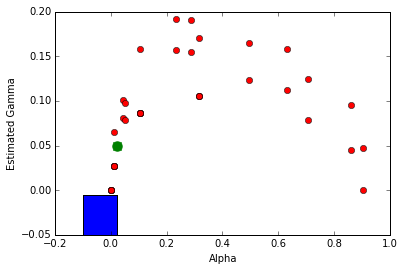

In [295]:
df = pd.read_csv('ncaa.data2.txt',delim_whitespace=True)
df.head()
x = df.ix[:,0:19]
y = df.ix[:,19]
fsr_fast(x,y,0.05,4,1)[0].summary()

In [296]:
ho = bag_fsr(x,y,100,0.05,fsr_fast,4)  

(0    -44.327079
1      0.021881
2      3.011726
3      0.214705
4      0.764621
5      0.216301
6      0.106215
7     -2.361223
8     -0.298818
9      1.143781
10    -0.000072
11     0.066673
12    -0.093154
13     0.033116
14     0.026811
15    -0.000000
16     0.049923
17    -0.037481
18    -0.032718
19     0.021964
dtype: float64, 0     19.629963
1      0.053562
2      0.939698
3      0.140278
4      0.286638
5      0.157552
6      0.135324
7      1.622961
8      0.460943
9      1.476677
10     0.000193
11     0.161593
12     0.264631
13     0.071869
14     0.199994
15     0.000001
16     0.136407
17     0.078907
18     0.076471
19     0.067228
dtype: float64, matrix([[ 37.6118],
        [ 52.8732],
        [ 54.8586],
        [ 51.0313],
        [ 54.9188],
        [ 51.4285],
        [ 60.1073],
        [ 85.7997],
        [ 61.0322],
        [ 67.3723],
        [ 53.9166],
        [ 63.9063],
        [ 58.4593],
        [ 59.6534],
        [ 98.2325],
        [ 44.875 ],
       

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  event   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     24.92
Date:                Sun, 26 Apr 2015   Prob (F-statistic):           4.53e-11
Time:                        00:19:19   Log-Likelihood:                -3810.5
No. Observations:                 532   AIC:                             7627.
Df Residuals:                     529   BIC:                             7640.
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        622.0209     48.880     12.725      0.000       525.998   718.044
cd40           0.8018      0.121      6.620      0.000         0.564     1.040
cd80          -0.1053      0.029     -3.622      0.000        -0.162    -0.048
==============================================================================
Omnibus:                       56.479   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.967
Skew:                          -0.596   Prob(JB):                     4.68e-10
Kurtosis:                       2.280   Cond. No.                     4.12e+03
==============================================================================

Warnings:
[1] The condition number is large, 4.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

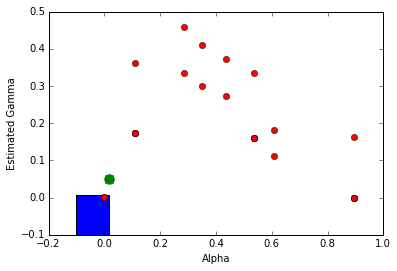

In [291]:
# Real Case 1: 12 linear variables 
df = pd.read_csv('actg.175.trt0.txt',delim_whitespace=True)
x = DataFrame(df, columns = ['cd40','cd80','age','wtkg','karnof','hemo','homo','drugs','race','gender','str2','symptom'])
y = df.ix[:,2]
fsr_fast(x,y,0.05,4,1)[0].summary()

In [293]:
ho = bag_fsr(x,y,100,0.05,fsr_fast,4)   
print ho

(0     648.699944
1       0.791876
2      -0.103357
3       0.080302
4      -0.591846
5       0.276773
6     -46.271976
7      12.615884
8     -11.657673
9     -20.765497
10     -0.520910
11     -5.801544
12    -13.124827
dtype: float64, 0     172.874008
1       0.119850
2       0.042034
3       0.723409
4       1.106170
5       1.391328
6      72.214007
7      34.434114
8      34.055185
9      36.714855
10     19.092501
11     18.573485
12     31.836969
dtype: float64, matrix([[  955.8446],
        [  761.9784],
        [  860.7675],
        [  791.4686],
        [  563.6031],
        [  818.1259],
        [  720.0956],
        [  784.178 ],
        [  729.6593],
        [  867.5916],
        [  693.2018],
        [  805.4746],
        [ 1153.2468],
        [  719.7291],
        [  781.2804],
        [  695.69  ],
        [  885.6893],
        [  795.5398],
        [  925.643 ],
        [  697.8143],
        [  868.3839],
        [  673.7654],
        [  929.7436],
        [  850.0288

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  event   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     26.76
Date:                Sun, 26 Apr 2015   Prob (F-statistic):           8.52e-12
Time:                        00:07:41   Log-Likelihood:                -3808.8
No. Observations:                 532   AIC:                             7624.
Df Residuals:                     529   BIC:                             7636.
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        526.9251     44.312     11.891      0.000       439.875   613.975
0              0.7830      0.120      6.544      0.000         0.548     1.018
32            -0.1600      0.039     -4.069      0.000        -0.237    -0.083
==============================================================================
Omnibus:                       52.216   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.574
Skew:                          -0.580   Prob(JB):                     1.55e-09
Kurtosis:                       2.303   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

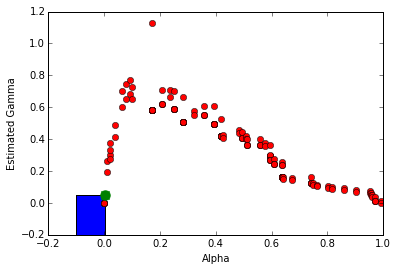

In [256]:
# Two function of cleaning the data and created the quadratic and interaction variables 83 variables
def io13():
    """Numpy loadtxt."""
    df = pd.read_csv('actg.175.trt0.txt',delim_whitespace=True)
    x = DataFrame(df, columns = ['cd40','cd80','age','wtkg','karnof','hemo','homo','drugs','race','gender','str2','symptom'])
    y = df.ix[:,2]
    x_15 = x.ix[:,0:5]
    x.ix[:,0:5] = x_15-x_15.mean()
    quadratic = (x.ix[:,0:5])**2
    count=-1
    new = np.zeros(shape=(df.shape[0],66))
    for i in range(x.shape[1]):
      for j in range(i+1,x.shape[1]):
           count = count+1
           new[:,count] = x.ix[:,i] * x.ix[:,j]
    X = DataFrame(df, columns = ['hemo','homo','drugs','race','gender','str2','symptom'])
    x = np.concatenate((x_15,X,quadratic,new),axis=1)
    x = pd.DataFrame(x)
    x.ix[:,63]=np.random.normal(0, 1, x.shape[0])
    return y,x

y = io13()[0]
x = io13()[1]

fsr_fast(x,y,0.05,4,1)[0].summary()

- Code optimization: too many loops 
- Programming optimization: vectorize the code and parallize programming
- algorithm optimization

# Method Comparision : Lasso, Ridge, Forward Selection with BIC

In [120]:
from sklearn.linear_model import Lasso
alpha = 0.5
lasso = Lasso(alpha=alpha, tol=0.001)
y_coef_lasso = lasso.fit(x, y).coef_
y_coef_lasso[np.round(y_coef_lasso,4) != 0].shape


(75,)

In [121]:
from sklearn.linear_model import Ridge
alpha = 0.5
ridge = Ridge(alpha=0.5,tol=0.001)
y_coef_ridge = ridge.fit(x, y).coef_
y_coef_ridge[np.round(y_coef_ridge,3) != 0].shape

(81,)

# Method Assesment and comparison

- Comparsion among lasso, fast fsr, ridge and forward selectino with BIC based on two criteria: Model Error Ratio 
  and False Selection Rate by the simulated data 
- In this simulation study, I simulated 100 data points with 42 variables. Four models are simulated: H1: all variables are zeros. H2: 6 variables are non-zeros at variables 6–8 and 13–15 with values (9,4,1). H3: 10 variables are non-zeros at variables 5–9 and 12–16 with values (25,16,9,4,1). H4: 14 variables are non-zeros at variables 4–10 and 11–17 with value (49, 36, 25, 16, 9, 4, 1)
- Plot the ME and FSR comparison plot for four models

In [122]:
def ME (method_coef,x,y,n):
    me=[]
    for i in range(n):
        me.append(np.sum((np.dot(method_coef,x.transpose())-y)**2)/150.0)
        i = i + 1
    return me


In [123]:
# function to find the False Selection Rate  
def FSRR (target,method_selected,n):
    l=[]
    for i in range(n):
      I = set(target)&set(method_selected)
      l.append((len(method_selected)-len(I))/(1.0+len(method_selected)))
      i = i+1
    return l

#  Parall pragramming

In [124]:
def pi_multiprocessing1(target,method,n):
    """Split a job of length n into num_procs pieces."""
    import multiprocessing
    m = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(m)
    mapfunc = partial(FSRR, target,method)
    results = pool.map(mapfunc,[n/m]*m)
    pool.close()
    return np.mean(results)


In [125]:
def pi_multiprocessing2(ME,method_coef,x,y,n):
    """Split a job of length n into num_procs pieces."""
    m = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(m)
    mapfunc = partial(ME,method_coef,x,y)
    results = pool.map(mapfunc,[n/m]*m)
    pool.close()
    return np.mean(results),min(min(results))

In [128]:
# Simulate the data set under model 1
x = pd.DataFrame(np.random.normal(1, 1, 21*150).reshape(150,21))
y = np.random.normal(1, 1, 150)
quad1 = (x.ix[:,0:20])**2
x = np.concatenate((x,quad1),axis=1)
x = pd.DataFrame(x)

alpha = 0.5
lasso = Lasso(alpha=alpha, tol=0.001)
y_coef_lasso = lasso.fit(x, y).coef_
lasso_index = np.where(y_coef_lasso != 0)[0]+1

target =[]
n = int(1e5)
print "LASSO FSR is",pi_multiprocessing1(target,lasso_index,n)


    

LASSO FSR is 0.0


In [129]:
target =[]
print "LASSO FSR is",pi_multiprocessing1(target,lasso_index,n)
me_r = pi_multiprocessing2(ME,y_coef_lasso,x,y,n)
print me_r
print "LASSO ME is",me_r[1]/me_r[0]
print "FAST FSR is",fsr_fast(x,y,0.05,4,0)[2]

LASSO FSR is 0.0
(1.8510745950583427, 1.8510745950583427)
LASSO ME is 1.0
FAST FSR is 0


In [ ]:
# Simulate the data under model 2 6–8 and 13–15
x = pd.DataFrame(np.random.normal(1, 1, 21*150).reshape(150,21))
y = 9*x.ix[:,5]+4*x.ix[:,6]+x.ix[:,7]+9*x.ix[:,12]+4*x.ix[:,13]+x.ix[:,14]
quad2 = (x.ix[:,0:20])**2
x = np.concatenate((x,quad2),axis=1)
x = pd.DataFrame(x)

alpha = 0.5
lasso = Lasso(alpha=alpha, tol=0.001)
y_coef_lasso = lasso.fit(x, y).coef_
lasso_index = np.where(y_coef_lasso != 0)[0]+1

n = int(1e5)
target = [6,7,8,13,14,15]

print "LASSO FSR is",pi_multiprocessing1(target,lasso_index,n) ##parallel programming 100 times then average
print "LASSO ME is",pi_multiprocessing2(ME,y_coef_lasso,x,y,n)
print "FAST FSR is",pi_multiprocessing1(target,fsr_fast(x,y,0.05,4,0)[2],n)

In [101]:
# Simulate the data under model 3 5–9 and 12–16 
x = pd.DataFrame(np.random.normal(1, 1, 21*150).reshape(150,21))
y = 25*x.ix[:,4]+16*x.ix[:,5]+9*x.ix[:,6]+4*x.ix[:,7]+1*x.ix[:,8]+25*x.ix[:,11]+16*x.ix[:,12]+9*x.ix[:,13]+4*x.ix[:,14]+1*x.ix[:,15]
quad3 = (x.ix[:,0:20])**2
x = np.concatenate((x,quad3),axis=1)
x = pd.DataFrame(x)


alpha = 0.5
lasso = Lasso(alpha=alpha, tol=0.001)
y_coef_lasso = lasso.fit(x, y).coef_
lasso_index = np.where(y_coef_lasso != 0)[0]+1



n = int(1e5)
target = [5,6,7,8,9,12,13,14,15,16]
print "LASSO FSR is",pi_multiprocessing1(target,lasso_index,n) ##parallel programming 100 times then average
print "LASSO ME is",pi_multiprocessing2(ME,y_coef_lasso,x,y,n)
print "FAST FSR is",pi_multiprocessing1(target,fsr_fast(x,y,0.05,4,0)[2],n)

 LASSO FSR is

NameError: global name 'partial' is not defined

In [548]:
# Simulate the data under model 4  4–10 and 11–17 
x = pd.DataFrame(np.random.normal(1, 1, 21*150).reshape(150,21))
y = 45*x.ix[:,3]+36*x.ix[:,4]+25*x.ix[:,5]+16*x.ix[:,6]+9*x.ix[:,7]+4*x.ix[:,8]+x.ix[:,9]+45*x.ix[:,10]+36*x.ix[:,11]+25*x.ix[:,12]+16*x.ix[:,13]+9*x.ix[:,14]+4*x.ix[:,15]+x.ix[:,16]
quad4 = (x.ix[:,0:20])**2
x = np.concatenate((x,quad4),axis=1)
x = pd.DataFrame(x) 

alpha = 0.5
lasso = Lasso(alpha=alpha, tol=0.001)
y_coef_lasso = lasso.fit(x, y).coef_
lasso_index = np.where(y_coef_lasso != 0)[0]+1

n = int(1e5)
target = [4,5,6,7,8,9,10,11,12,13,14,15,16]
print "LASSO FSR is",pi_multiprocessing1(target,lasso_index,n) ##parallel programming 100000 times then average
print "LASSO ME is",pi_multiprocessing2(ME,y_coef_lasso,x,y,n)
print "FAST FSR is",pi_multiprocessing1(target,fsr_fast(x,y,0.05,4,0)[2],n)

LASSO FSR is 0.518518518519
LASSO ME is (123.85160024467945, 123.85160024465611)
FAST FSR is 0.125


# Profiling the Functions and Optimizing the code by parall pragramming 

In [547]:
n = int(1e5)
%timeit pi_multiprocessing1(target,lasso_index,n)
%timeit np.mean(FSRR(target,lasso_index,n))

1 loops, best of 3: 426 ms per loop
1 loops, best of 3: 809 ms per loop


Exception in thread Thread-1201:
Traceback (most recent call last):
  File "/home/bitnami/anaconda/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/home/bitnami/anaconda/lib/python2.7/site-packages/zmq/utils/garbage.py", line 34, in run
    s.bind(self.gc.url)
  File "socket.pyx", line 444, in zmq.backend.cython.socket.Socket.bind (zmq/backend/cython/socket.c:4076)
  File "checkrc.pxd", line 21, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/socket.c:6032)
ZMQError: Address already in use


In [546]:
! pip install --pre line-profiler &> /dev/null
! pip install psutil &> /dev/null
! pip install memory_profiler &> /dev/null

In [83]:
%timeit -r1 -n1 fsr_fast(x,y,.05,4,0)
%timeit -r1 -n1 io13(interaction)

1 loops, best of 1: 143 ms per loop
1 loops, best of 1: 29 ms per loop


In [85]:
stat = %prun -r -q fsr_fast(x,y,.05,4,0)
stat.sort_stats('time').print_stats(10)

          132355 function calls (132010 primitive calls) in 0.169 seconds

   Ordered by: internal time
   List reduced from 458 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      166    0.024    0.000    0.060    0.000 doccer.py:12(docformat)
      168    0.016    0.000    0.018    0.000 numpy2ri.py:42(numpy2ri)
       86    0.016    0.000    0.016    0.000 {sum}
     5146    0.011    0.000    0.011    0.000 {method 'expandtabs' of 'str' objects}
       85    0.008    0.000    0.008    0.000 {method 'rcall' of 'rpy2.rinterface.SexpClosure' objects}
      166    0.008    0.000    0.012    0.000 doccer.py:128(indentcount_lines)
     5146    0.007    0.000    0.007    0.000 {method 'splitlines' of 'str' objects}
        1    0.006    0.006    0.049    0.049 functions.py:95(__call__)
    50400    0.004    0.000    0.004    0.000 {method 'append' of 'list' objects}
       83    0.003    0.000    0.087    0.001 _distn_infrastructure.

<pstats.Stats instance at 0x7f06f3183dd0>

In [86]:
stat.sort_stats('time').print_stats(r'ipython')

         132355 function calls (132010 primitive calls) in 0.169 seconds

   Ordered by: internal time
   List reduced from 458 to 1 due to restriction <'ipython'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.179    0.179 <ipython-input-75-5fd1a2e39ab4>:2(fsr_fast)




<pstats.Stats instance at 0x7f06f3183dd0>

In [88]:
%load_ext memory_profiler

In [89]:
%memit fsr_fast(x,y,.05,4,0)

peak memory: 188.52 MiB, increment: 0.02 MiB


- 1.how to improve the input reading speed? necessary use numpy.load or not?
- 2.how to detect which part should be improved? based on my running time for the functions
- 3.does my memory use too much memory for the data?
- 4.comparision : glmnet result lasso julia?
- 5.one column covariance equals to zero.....add random value to it....?
- 6.julia? can i solve it????

# Draft of Make Files:



- make -f MyMakefile
- target: dependencies
- make -f Makefile-1